In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(6432, 24)
(6432, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_RR_swinging = X_motion[idxs]
Y_motion_RR_swinging = Y_motion[idxs]

## Predict RR foot -> x

In [8]:
X_motion_RR_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.22449669,  0.12662344, -0.38287407,  0.25448346,
       -0.12627079, -0.36686563, -0.2433899 ,  0.12268152, -0.37084204,
       -0.27261013, -0.12962829, -0.38346642,  0.1107618 , -0.00494386,
       -0.05758817, -0.0046587 ,  1.        ,  0.        ])

In [9]:
Y_motion_RR_swinging[0, :]

array([0.07247222, 0.00360037, 0.07030449, 0.00479195])

### Linear Regression

In [20]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # Previous motion command
               X_motion_RR_swinging[:, 3:6], # Current motion command
               #X_motion_RR_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RR_swinging[:, 6:8], # FL (x,y) position
               X_motion_RR_swinging[:, 9:11], # FR (x,y) position
               X_motion_RR_swinging[:, 12:14], # RL (x,y) position
               X_motion_RR_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9721921446315356
RMSE:  0.02090061024571644
The lowest error is:  3.357488380428819e-06
The highest error is:  0.11443034169910471
The avg. error is:  0.014334259537747054


In [21]:
model_rr_relative_swinging_x.coef_

array([[ 5.68535333e-03, -8.88178420e-16, -1.33226763e-15,
         2.09583926e-01, -4.44089210e-16,  2.22044605e-16,
         1.25314280e+00, -1.07228066e+00,  4.04180408e-01,
         1.53673760e+00,  3.04358529e-01,  2.17394677e-01,
        -3.55599146e+00, -1.26152628e+00]])

In [22]:
model_rr_relative_swinging_x.intercept_

array([-1.09648662])

Text(0, 0.5, 'Predictions')

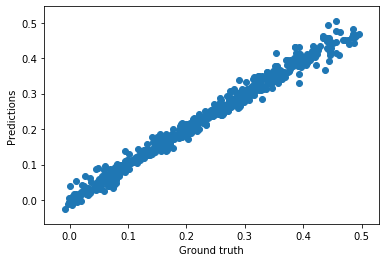

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_rr_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [23]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # Previous motion command
               X_motion_RR_swinging[:, 3:6], # Current motion command
               #X_motion_RR_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RR_swinging[:, 6:8], # FL (x,y) position
               X_motion_RR_swinging[:, 9:11], # FR (x,y) position
               X_motion_RR_swinging[:, 12:14], # RL (x,y) position
               X_motion_RR_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -0.4919680901796024
RMSE:  0.006484088404041656
The lowest error is:  2.5441467233489057e-06
The highest error is:  0.037794240952780306
The avg. error is:  0.0045189005531823395


In [24]:
model_rr_relative_swinging_y.coef_

array([[ 1.98410606e-03, -4.85722573e-17, -4.44089210e-16,
         5.30420523e-03,  1.11022302e-16,  5.55111512e-17,
         2.77089864e-01, -7.28364830e-01,  5.17911377e-02,
         3.88363660e-01, -8.04528198e-02,  3.29369386e-01,
        -4.18785721e-01, -6.47946453e-01]])

In [25]:
model_rr_relative_swinging_y.intercept_

array([-0.19201532])

Text(0, 0.5, 'Predictions')

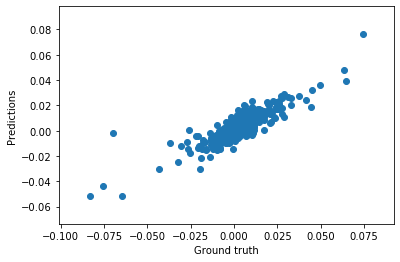

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')